In [26]:
import os
os.chdir('C:/Users/bclamber/Desktop/AllPints/pints3/pints')
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Multinormal density fitting using Sequential Monte Carlo

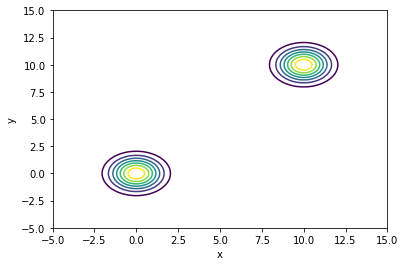

In [27]:
# Create log pdf
log_pdf = pints.toy.MultimodalNormalLogPDF()

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [-5, -5],
    [15, 15]
)

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [28]:
# Select mean and variance matrix of initial proposal dist
x0 = [5, 5]
sigma0 = [[2, 0], [0,2]]

# Create mcmc routine
sampler = pints.SMC(log_pdf, x0, sigma0, log_prior)

# Set number of temperatures (uniform on log scale)
sampler.set_temperature_schedule(5)

# Set number of particles
sampler.set_particles(5000)

# Set number of MCMC steps at each temperature
sampler.set_kernel_samples(3)

# Run sampler
samples = sampler.run()

Running sequential Monte Carlo
Total number of particles: 5000
Number of temperatures: 5
Resampling at end of each iteration
Number of MCMC steps at each temperature: 3
Storing 1 sample per 1 particle
Sampling from distribution of temperature: 0.001
Sampling from distribution of temperature: 0.01
Sampling from distribution of temperature: 0.1
Sampling from distribution of temperature: 1.0


C:\Users\bclamber\Desktop\AllPints\pints3\pints\pints\_sequential\_sequentialMC.py:214: RuntimeWarning: invalid value encountered in double_scalars
  return beta * self._log_posterior(x) + (1 - beta) * self._log_prior(x)
C:\Users\bclamber\Desktop\AllPints\pints3\pints\pints\_sequential\_sequentialMC.py:265: RuntimeWarning: invalid value encountered in less_equal
  if r <= np.random.uniform(size=1):


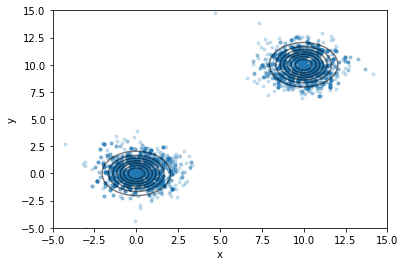

In [29]:
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(samples[:,0], samples[:,1], marker='.', alpha=0.2)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Logistic model fitting

In [30]:
# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [-5, 400, noise*0.1],
    [5, 600, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Select mean and variance matrix of initial proposal dist
x0 = [0.015,500,10]

# Create mcmc routine
sampler = pints.SMC(log_posterior, x0, log_prior=log_prior)

# Set number of particles
sampler.set_particles(5000)

# Don't resample at end of steps 2 and 3 in Del Moral et al. (2006) Algorithm 3.1.1
sampler.set_resample_end_2_3(False)

# Set ESS resampling threshold (resamples every iteration with this)
sampler.set_ess_threshold(5)

# Run sampler
samples = sampler.run()

Running sequential Monte Carlo
Total number of particles: 5000
Number of temperatures: 10
Not resampling at end of each iteration
Number of MCMC steps at each temperature: 1
Storing 1 sample per 1 particle
Sampling from distribution of temperature: 0.000278255940221
Sampling from distribution of temperature: 0.000774263682681
Sampling from distribution of temperature: 0.00215443469003


C:\Users\bclamber\Desktop\AllPints\pints3\pints\pints\_sequential\_sequentialMC.py:264: RuntimeWarning: overflow encountered in exp
  - self.tempered_distribution(samples[i], beta))


Sampling from distribution of temperature: 0.00599484250319
Sampling from distribution of temperature: 0.016681005372
Sampling from distribution of temperature: 0.0464158883361
Sampling from distribution of temperature: 0.129154966501
Sampling from distribution of temperature: 0.35938136638
Sampling from distribution of temperature: 1.0


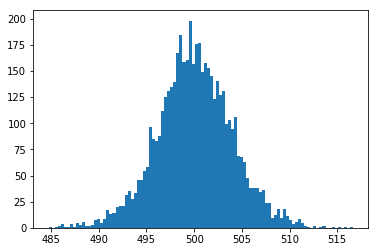

In [31]:
plt.hist(samples[:, 1],100)
plt.show()